In [29]:
import json
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import scipy.signal

In [30]:
def read_our(filename):
    with open(filename) as file:
        time, pressure, flow = [], [], []
        for line in file:
            try:
                row = json.loads(line)
            except:
                pass
            else:
                time.append(row["t"] / 1000.0)
                pressure.append(0.0126 * row["P"] - 12.73)
                flow.append(0.7198 * np.sign(row["F"])*abs(row["F"])**(4/7))
        return np.array(time), np.array(pressure), np.array(flow)

In [31]:
time, pressure, flow = read_our("../penn-2020-04-22/helmet-data0143.out")

In [36]:
rawvolume = scipy.integrate.cumtrapz(flow, time / 60.0, initial=0)
ourvolume = scipy.signal.sosfilt(scipy.signal.butter(1, 0.004, "highpass", output="sos"), rawvolume)
ourvolume -= ourvolume[6100:15500].min()

In [55]:
volume_by_average = scipy.integrate.cumtrapz(flow - flow[6100:15500].mean(), time / 60.0, initial=0)
volume_by_average -= volume_by_average[6100:15500].min()

In [56]:
pressure_average = 0.25*(
    pressure[4:] +
    pressure[3:-1] +
    pressure[1:-3] +
    pressure[:-4])

toreplace22 = abs(
    pressure_average -
    pressure[2:-2]) > 0.1
toreplace = np.zeros(
    len(pressure), np.bool_)
toreplace[2:-2] = toreplace22

pressure_deglitched = pressure.copy()
pressure_deglitched[toreplace] = \
    pressure_average[toreplace22]

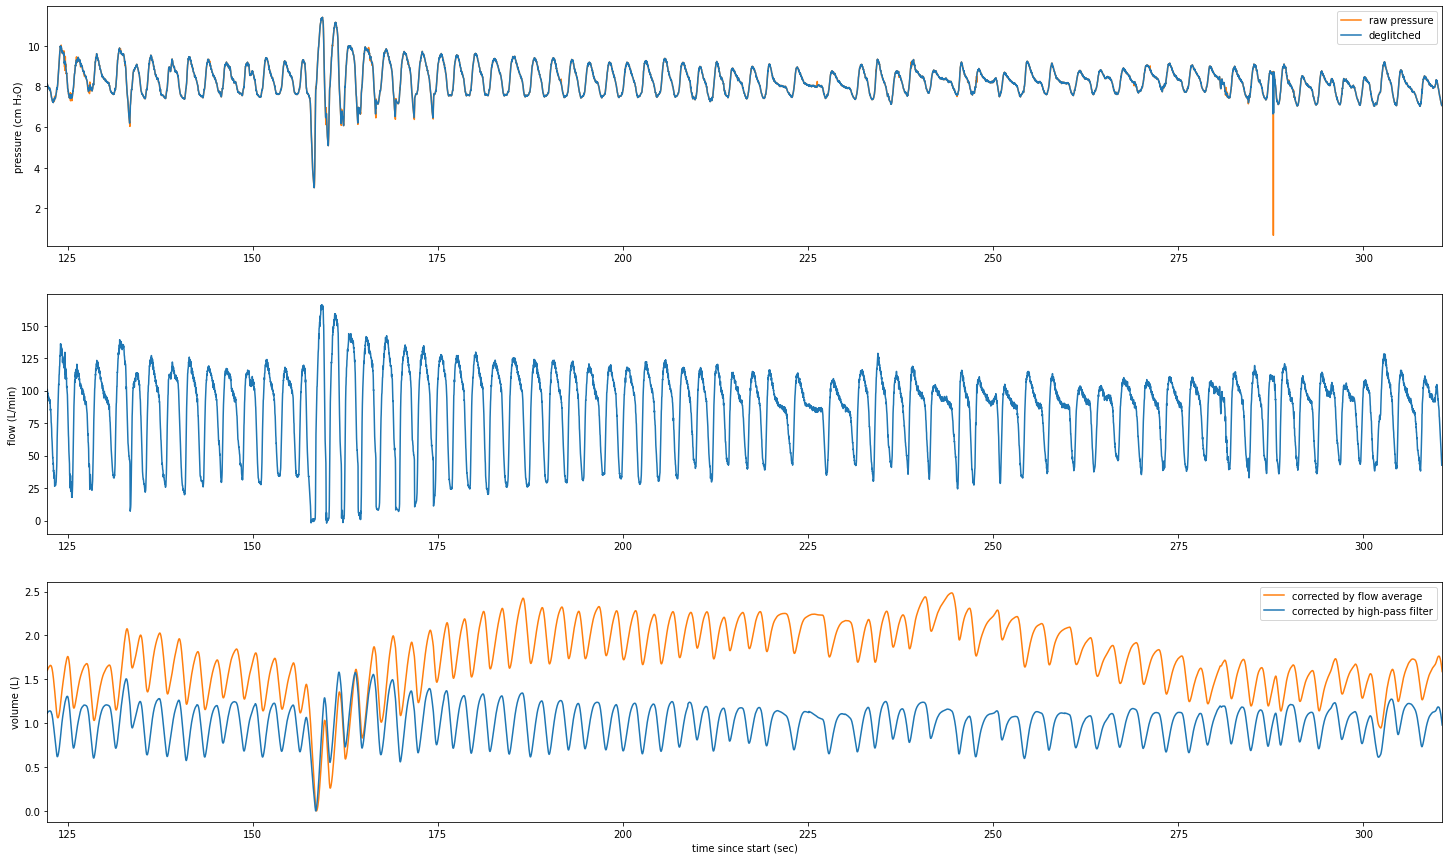

In [64]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(25, 15))
rawpressure, = ax1.plot(time[6100:15500] - time[0], pressure[6100:15500], color='#ff7f0e')
deglitched, = ax1.plot(time[6100:15500] - time[0], pressure_deglitched[6100:15500], color='#1f77b4')
ax1.legend([rawpressure, deglitched], ["raw pressure", "deglitched"], loc="upper right")
ax1.set_ylabel("pressure (cm H₂O)")
ax1.set_xlim(time[6100] - time[0], time[15500] - time[0])
ax2.plot(time[6100:15500] - time[0], flow[6100:15500])
ax2.set_ylabel("flow (L/min)")
ax2.set_xlim(time[6100] - time[0], time[15500] - time[0])
byaverage, = ax3.plot(time[6100:15500] - time[0], volume_by_average[6100:15500], color='#ff7f0e')
byhighpass, = ax3.plot(time[6100:15500] - time[0], ourvolume[6100:15500], color='#1f77b4')
ax3.legend([byaverage, byhighpass], ["corrected by flow average", "corrected by high-pass filter"])
ax3.set_ylabel("volume (L)")
ax3.set_xlim(time[6100] - time[0], time[15500] - time[0])
ax3.set_xlabel("time since start (sec)")
fig.savefig("/tmp/helmet-data.png")

In [66]:
(300 - 125) / 60

2.9166666666666665